In [1]:
import tensorflow as tf # Машинное обучение
import keras # API для TensorFlow
import numpy as np # Научные вычисления
import matplotlib.pyplot as plt # Визуализация 2D и 3D графики
import pandas as pd # Обработка и анализ данных
import matplotlib as mpl # Визуализация графиков
import random # Генерация псевдослучайных чисел для различных распределений
import seaborn as sns # Визуализация графиков (надстройка над matplotlib)
import pylab # Построение графиков
import os # Взаимодействие с файловой системой
import matplotlib.image as mpimg # Работа с изображениями
import cv2 # Компьютерное зрение
from pathlib import Path # Работа с путями в файловой системе

from keras import applications # Предобученные модели глубокого обучения

### Версии необходимых библиотек

In [2]:
pkgs = {
    'Package': ['TensorFlow', 'Keras', 'NumPy', 'Pandas', 'Matplotlib', 'Seaborn'],
    'Version': [i.__version__ for i in [tf, keras, np, pd, mpl, sns]]}

df_pkgs = pd.DataFrame(data = pkgs) # Версии используемых библиотек
df_pkgs.head(None).style.hide_index() # Отображение первых N строк или все если указать None

Package,Version
TensorFlow,2.3.1
Keras,2.4.3
NumPy,1.18.5
Pandas,1.1.3
Matplotlib,3.3.2
Seaborn,0.11.0


### Каталоги набора данных

In [3]:
dir = '../lr9/Lectures/'

dir = os.path.join(dir, 'plates') # Набор данных (тарелки)

# Обучающая выборка
train_cleaned_dir = os.path.join(dir, 'train/cleaned') # Класс 1
train_dirty_dir = os.path.join(dir, 'train/dirty') # Класс 2

### Пример имен файлов

In [4]:
def list_dir_filter(path, inc_ext = ['jpg']):
    """
    Фильтрация списка файлов

    (str, list) -> list

    Аргументы:
        path - Путь к файлам
        inc_ext - Расширения

    Возвращает: list - отфильтрованный список файлов
    """
    
    return [f for f in os.listdir(path) if any(f.endswith(ext) for ext in inc_ext)]

# Списки файлов (Обучающая выборка)
train_cleaned_names = list_dir_filter(train_cleaned_dir)
train_dirty_names = list_dir_filter(train_dirty_dir)

# Отображение в DataFrame
list_of_files = {
    'Cleaned': train_cleaned_names,
    'Dirty': train_dirty_names
}

# Отображение в DataFrame
df_files = pd.DataFrame.from_dict(data = list_of_files, orient = 'index').transpose()
df_files[:10].head(None) # Отображение первых N строк или все если указать None

,Cleaned,Dirty
0,0000.jpg,0000.jpg
1,0001.jpg,0001.jpg
2,0002.jpg,0002.jpg
3,0003.jpg,0003.jpg
4,0004.jpg,0004.jpg
5,0005.jpg,0005.jpg
6,0006.jpg,0006.jpg
7,0007.jpg,0007.jpg
8,0008.jpg,0008.jpg
9,0009.jpg,0009.jpg


### Количество элементов в каждом классе

In [5]:
print('Обучающий набор:')
print('\tВсего изображений чистых тарелок:', len(df_files.Cleaned))
print('\tВсего изображений грязных тарелок:', len(df_files.Dirty))

Обучающий набор:
	Всего изображений чистых тарелок: 20
	Всего изображений грязных тарелок: 20


### Отображение изображений из обучающей выборки

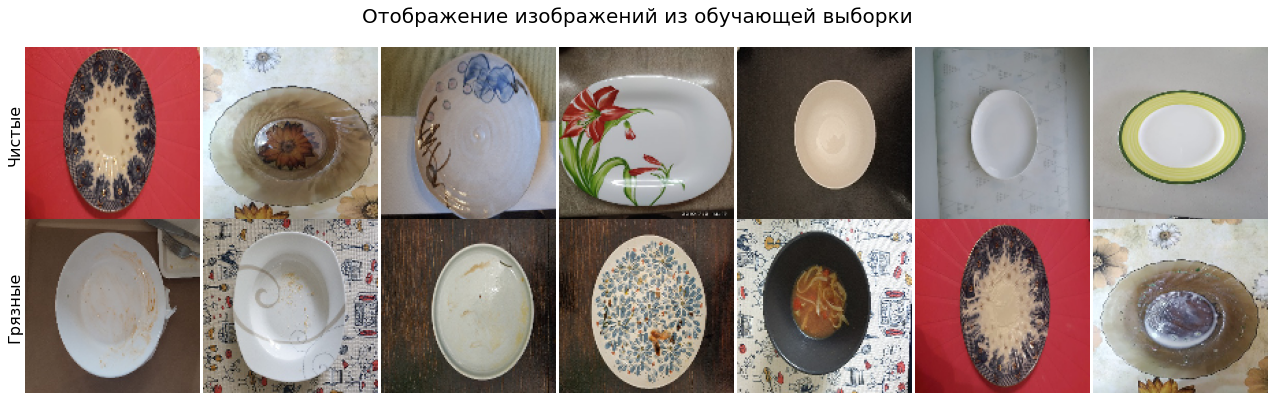

In [6]:
resize_img = (128, 128)

nrows = 2 # Количество строк
ncols = 7 # Количество столбцов

counts = 7 # Количество случайных значений из обучающего набора данных

fig = plt.gcf() # Создание фигуры
fig.set_size_inches(ncols * 2.5, nrows * 2.55) # Установка размера фигуры в дюймах

labels = ['Чистые', 'Грязные'] # Классы

mpl.rcParams['axes.linewidth'] = 0 # Толщина рамки

# Случайные номера изображений из обучающего набора
next_cleaned_pix = random.sample(range(0, len(df_files.Cleaned)), counts) # Чистые
next_dirty_pix = random.sample(range(0, len(df_files.Dirty)), counts) # Грязные

next_cleaned_pix = [
    os.path.join(train_cleaned_dir, df_files.iloc[fname].Cleaned) for fname in next_cleaned_pix
]
next_dirty_pix = [
    os.path.join(train_dirty_dir, df_files.iloc[fname].Dirty) for fname in next_dirty_pix
]

for i, img_path in enumerate(next_cleaned_pix + next_dirty_pix):
    sp = plt.subplot(nrows, ncols, i + 1)
    
    # Скрытие осей
    plt.setp(sp.get_xticklabels(), visible = False)
    plt.setp(sp.get_yticklabels(), visible = False)
    plt.xticks([])
    plt.yticks([])
    
    img = mpimg.imread(img_path)
    
    # Уменьшение изображения
    img_small = cv2.resize(img, dsize = resize_img, interpolation = cv2.INTER_CUBIC)
    
    plt.imshow(img_small)
    
    if i % counts == 0:
        sp.set_ylabel(
            labels[i // counts],
            fontsize = 16, # Размер метки
            fontdict = {
                'color': '#000000' # Цвет метки
            },
            labelpad = 3 # Отступ
        )

plt.suptitle(
    'Отображение изображений из обучающей выборки', # Заголовок
    fontsize = 20, # Размер заголовка
    fontdict = {
        'color': '#000000' # Цвет заголовка
    },
    y = 1.055 # Отступ заголовка от вершины осей
)

plt.tight_layout(pad = 0) # Установка расстояния между осями

plt.show() # Отображение фигуры

### Дополнительный импорт

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Формирование набора данных для TF

### Предварительная обработка данных

In [8]:
target_size = (224, 224)

# Аугментация
train_datagen = ImageDataGenerator(
    rotation_range = 40, # Диапазон углов поворота от 0 до 180 градусов, на который случайным образом поворачивается изображение
    width_shift_range = 0.2, # Сдвиг изображения по ширине
    height_shift_range = 0.2, # Сдвиг изображения по высоте
    shear_range = 0.2, # Искажение
    zoom_range = 0.2, # Увеличение/уменьшение изображения
    horizontal_flip = True, # Зеркальный поворот
    fill_mode = 'nearest', # Заливка пустых пикселей, который потеряны при аугментации
    rescale = 1 / 255 # Нормализация набора изображений и диапазона [0:255] в диапазоне [0:1]
)

# Аугментация
test_datagen = ImageDataGenerator(
    rotation_range = 20, # Диапазон углов поворота от 0 до 180 градусов, на который случайным образом поворачивается изображение
    width_shift_range = 0.2, # Сдвиг изображения по ширине
    height_shift_range = 0.2, # Сдвиг изображения по высоте
    shear_range = 0.2, # Искажение
    zoom_range = 0.2, # Увеличение/уменьшение изображения
    horizontal_flip = True, # Зеркальный поворот
    fill_mode = 'nearest', # Заливка пустых пикселей, который потеряны при аугментации
    rescale = 1 / 255 # Нормализация набора изображений и диапазона [0:255] в диапазоне [0:1]
)

# Формирование обучающей выборки
train_generator = train_datagen.flow_from_directory(
    os.path.join(dir, 'train'), # Корневая директория
    target_size = target_size, # Размер изображений
    batch_size = 10, # Размер выборки
    class_mode = 'binary' # Формат классификации
)

# Формирование валидационной выборки
test_generator = test_datagen.flow_from_directory(
    os.path.join(dir, 'train'), # Корневая директория
    target_size = target_size, # Размер изображений
    batch_size = 10, # Размер выборки
    class_mode = 'binary' # Формат классификации
)

Found 40 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


### Определение базовой модели нейронной сети

In [9]:
def create_model():
    """
    Создание модели нейронной сети
    
    Возвращает: keras.engine.sequential.Sequential
    """
    
    base_model = keras.applications.MobileNetV2(
        input_shape = (target_size[0], target_size[1], 3), # Размер входных данных
        include_top = False, # Игнорирование полносвязного слоя
        weights = 'imagenet' # Веса модели
    )

    for layer in base_model.layers:
        layer.trainable = False
    
    # Определение модели нейронной сети
    # Преобразование массива пикселей в вектор пикселей
    x = keras.layers.Flatten()(base_model.output)

    # Полносвязный скрытый слой
    x = keras.layers.Dense(
        units = 1024, # Количество нейронов
        activation = tf.nn.relu # Функция активации
    )(x)

    x = keras.layers.Dropout(0.5)(x) # Прореживание

    # Полносвязный слой
    x = keras.layers.Dense(1, activation = 'sigmoid')(x)         

    # Модель
    model = keras.models.Model(base_model.input, x)
    
    # Сборка модели
    model.compile(
        # Оптимизатор
        optimizer = tf.keras.optimizers.Adam(
            lr = 0.0001 # Скорость обучения
        ),
        loss = 'binary_crossentropy', # Функция потерь
        metrics = ['accuracy'] # Метрика оценивания
    )
    
    return model

### Обратный вызов во время обучения

In [10]:
from sklearn.metrics import accuracy_score

class CustomCallback(keras.callbacks.Callback):
    # Конструктор
    def __init__(self, dir):
        super().__init__() # Выполнение конструктора из суперкласса
        
        self.df = pd.DataFrame({
            'Accuracy': [],
            'Val accuracy': [],
            'Loss': [],
            'Val loss': [],
        })
        
        self.test_datagen = ImageDataGenerator(
            rescale = 1 / 255
        )

        self.test_generator = self.test_datagen.flow_from_directory(  
                os.path.join(dir),
                classes = ['test'],
                target_size = target_size,
                batch_size = 1,
                shuffle = False,
                class_mode = 'binary'
        )
        
        self.sub = pd.read_csv('../lr9/Lectures/plates/final.csv')
        
        self.best_metrics = {'acc': None, 'epoch': None} # Лучшая модель
        
        self.sub_df = pd.read_csv('../lr9/Lectures/plates/sample_submission.csv')
    
    # Вызывается в конце эпохи во время тренировки
    def on_epoch_end(self, epoch, logs = None):
        train_acc = logs.get('accuracy') # Точность на обучающем наборе
        val_acc = logs.get('val_accuracy') # Точность на валидационном наборе
        train_loss = logs.get('loss') # Loss на обучающем наборе
        val_loss = logs.get('val_loss') # Loss на валидационном наборе

        self.df = self.df.append(
            pd.Series([train_acc, val_acc, train_loss, val_loss], index = self.df.columns),
            ignore_index = True
        )

        self.test_generator.reset()
        predict = self.model.predict_generator(self.test_generator, steps = len(self.test_generator.filenames))

        self.sub_df['label'] = predict
        self.sub_df['label'] = self.sub_df['label'].apply(lambda x: 'dirty' if x > 0.5 else 'cleaned')

        self.sub_df.to_csv('../lr9/Lectures/plates/sub.csv', index = False)


        self.sub_df = pd.read_csv('../lr9/Lectures/plates/sub.csv')

        acc = round(accuracy_score(self.sub.label, self.sub_df.label), 4)

        if (self.best_metrics['acc'] is None or self.best_metrics['acc'] < acc):
            self.best_metrics['acc'] = acc
            self.best_metrics['epoch'] = epoch + 1

            print('\n----- Теперь лучшая точность:', acc, '-----')
        
            model_json = self.model.to_json()
            with open('../lr9/Lectures/plates/best.json', 'w') as json_file:
                json_file.write(model_json)
            self.model.save_weights('../lr9/Lectures/plates/best.h5')
        
            # Сравнение точности на текущей эпохе
            if(acc >= 0.93):
                  self.model.stop_training = True # Остановка обучения
        else:
            print('\nЖаль:', acc, '-----')

In [11]:
# Контрольные точки
model_checkpoint = keras.callbacks.ModelCheckpoint(
    '../lr9/Lectures/plates/epoch_{epoch:02d}_acc_{val_accuracy:.4f}.h5',
    monitor = 'val_loss',
    save_weights_only = True,
    save_best_only = False,
    verbose = 0
)

### Обучение модели

In [12]:
ext = ['.h5'] # Расширения

# Файлы моделей
files = {
    p.resolve() for p in Path('../lr9/Lectures/plates').glob('*')
    if p.suffix in ext
}

# Проход по всем моделям
for i, f in enumerate(files):
    os.remove(f)

model = create_model()

callbacks = CustomCallback(dir) # Остановка процесса обучения

history = model.fit(
    train_generator, # Обучающая выборка
    epochs = 9, # Количество эпох
    verbose = 1, # Отключение вывода
    validation_data = test_generator, # Валидационная выборка
    validation_steps = None, # Шаг валидации
    callbacks = [callbacks] # Вызов функции после каждой эпохи
)

Found 744 images belonging to 1 classes.
Epoch 1/9
4/4 [==============================] - ETA: 0s - loss: 3.3638 - accuracy: 0.4500WARNING:tensorflow:From <ipython-input-10-c4347d5fa12d>:47: Model.predict_generator (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
Please use Model.predict, which supports generators.

----- Теперь лучшая точность: 0.6626 -----
4/4 [==============================] - 37s 9s/step - loss: 3.3638 - accuracy: 0.4500 - val_loss: 1.2443 - val_accuracy: 0.7000
Epoch 2/9
4/4 [==============================] - ETA: 0s - loss: 1.2290 - accuracy: 0.6750
----- Теперь лучшая точность: 0.7137 -----
4/4 [==============================] - 35s 9s/step - loss: 1.2290 - accuracy: 0.6750 - val_loss: 0.7757 - val_accuracy: 0.8500
Epoch 3/9
4/4 [==============================] - ETA: 0s - loss: 1.0423 - accuracy: 0.8250
----- Теперь лучшая точность: 0.7231 -----
4/4 [==============================] 

In [13]:
callbacks.best_metrics

{'acc': 0.7648, 'epoch': 4}

### Визуализация процесса обучения

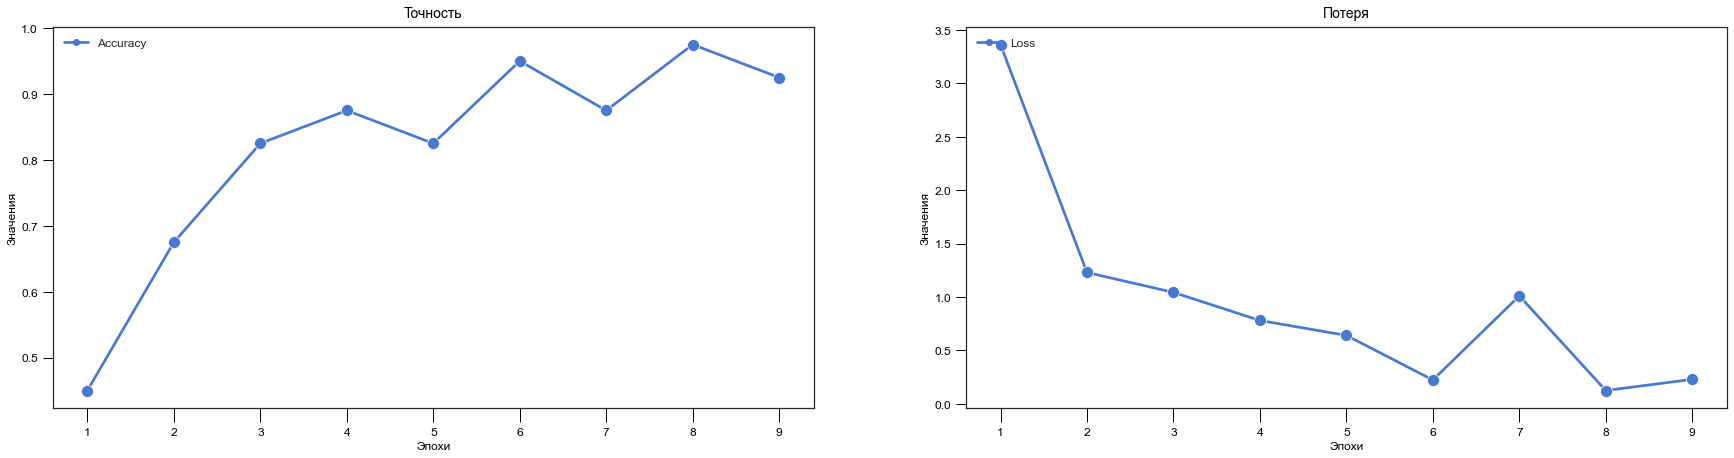

In [14]:
# Создание новой фигуры
fig = plt.figure(
    figsize = (30, 7) # Размер фигуры в дюймах
)

# Установка эстетических параметров
sns.set(
    style = 'white', # Стиль
    palette = 'muted', # Пальтра
    color_codes = True,
    rc = {'lines.linewidth': 2.7}
)
sns.despine(left = True)

cols = 2 # Количество столбцов
rows = 1 # Количество строк

titles = ['Точность', 'Потеря']

df = pd.DataFrame({
    'Accuracy': history.history['accuracy'],
    'Loss': history.history['loss'],
})

epochs = range(len(df['Accuracy'])) # Количество эпох

columns = df.columns.tolist() # Список заголовков столбцов

len_columns = int(len(columns) / 2) # Количество графиков на каждой оси

cnt = 0 # Счетчик

# Проход по всем строкам
for i in range(0, rows):
    # Проход по всем столбцам
    for j in range(0, cols):
        # Создание оси в определенном месте внутри регулярной сетки
        ax = pylab.subplot2grid((rows, cols),(i, j))
        
        df_slice = df.loc[:, columns[cnt:len_columns]] # Срез
        
        # Увеличение счетчиков для среза
        cnt += len_columns
        len_columns += len_columns
        
        # Линейный график
        ax = sns.lineplot(data = df_slice, dashes = False, markers = ['o'], markersize = 12)
    
        ax.set_xticks(epochs) # Количество отчетов
        ax.set_xticklabels(range(1, len(epochs) + 1)) # Эпохи в верном диапазоне
        
        # Заголовок осей
        ax.set_title(
            label = titles[j], # Заголовок
            fontdict = {
                'fontsize': 14, # Размер заголовка
                'color': '#000000' # Цвет заголовка
            },
            pad = 10 # Отступ заголовка от вершины осей
        )
        
        # Изменение внешнего вида меток
        ax.tick_params(
            axis = 'x', # Ось
            direction = 'out', # Расположение линий меток
            length = 14, # Длина линий меток
            width = 1, # Ширина линий меток 
            color = '#000000', # Цвет линий меток
            pad = 5, # Расстояние между линиями меток и метками
            labelsize = 12, # Размер метки
            labelcolor = '#000000', # Цвет метки
            bottom = True,  # Рисование линий меток
        )
        ax.tick_params(
            axis = 'y', # Ось
            direction = 'out', # Расположение линий меток
            length = 10, # Длина линий меток
            width = 1, # Ширина линий меток 
            color = '#000000', # Цвет линий меток
            pad = 5, # Расстояние между линиями меток и метками
            labelsize = 12, # Размер метки
            labelcolor = '#000000', # Цвет метки
            left = True  # Рисование линий меток
        )
        
        # Изменение внешнего вида меток данных
        ax.set_xlabel(
            'Эпохи',
            fontsize = 12, # Размер метки
            fontdict = {
                'color': '#000000' # Цвет метки
            },
            labelpad = 4 # Отступ

        )
        ax.set_ylabel(
            'Значения',
            fontsize = 12, # Размер метки
            fontdict = {
                'color': '#000000' # Цвет метки
            },
            labelpad = 4 # Отступ
        )
        
        ax.legend(loc='upper left', frameon = False, fontsize = 12)